In [ ]:
!nvidia-smi

Sun Oct 15 09:31:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installation

In [ ]:
# install the audiocraft liabrary from github
!python3 -m pip install -U git+https://github.com/facebookresearch/audiocraft#egg=audiocraft

  Cloning https://github.com/facebookresearch/audiocraft to /tmp/pip-install-utjq12u4/audiocraft_6cb4cd7f547045bd98a77ee9d31d376c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/audiocraft /tmp/pip-install-utjq12u4/audiocraft_6cb4cd7f547045bd98a77ee9d31d376c
  Resolved https://github.com/facebookresearch/audiocraft to commit 5d8752d3568858f1f77747dfb82b40ef9538c4b2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 9.2 MB/s eta 0:00:00
  Prepar

# Import necessary libraries

In [ ]:
# import necessary libraries
from audiocraft.models import musicgen
from audiocraft.utils.notebook import display_audio
import torch
from audiocraft.data.audio import audio_write
import torchaudio

# Loading the model

In [ ]:
# | model types are =>      small,  medium,   melody,   large |
# | size of models are =>   300M,   1.5B,     1.5B,     3.3B  |

# model = musicgen.MusicGen.get_pretrained('large', device='cuda')
model = musicgen.MusicGen.get_pretrained('melody', device='cuda')
# model = musicgen.MusicGen.get_pretrained('medium', device='cpu')

/usr/local/lib/python3.10/dist-packages/audiocraft/models/musicgen.py:112: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-melody
  warnings.warn(


Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/955717e8-8726e21a.th" to /root/.cache/torch/hub/checkpoints/955717e8-8726e21a.th
100%|██████████| 80.2M/80.2M [00:00<00:00, 105MB/s]


# Setting the parameters

In [ ]:
# default values for the generation parameters
default_generation_params = {
    'use_sampling': True,
    'temp': 1.0,
    'top_k': 250,
    'top_p': 0.0,
    'cfg_coef': 3.0,
    'two_step_cfg': False
}

new_generation_params = {}
new_generation_params['use_sampling'] = input("Use sampling (True/False): ").lower() == 'true'
temp_input = input(f"Temperature ({default_generation_params['temp']}): ")
new_generation_params['temp'] = float(temp_input) if temp_input else default_generation_params['temp']
top_k_input = input(f"Top-k ({default_generation_params['top_k']}): ")
new_generation_params['top_k'] = int(top_k_input) if top_k_input else default_generation_params['top_k']
top_p_input = input(f"Top-p ({default_generation_params['top_p']}): ")
new_generation_params['top_p'] = float(top_p_input) if top_p_input else default_generation_params['top_p']
cfg_coef_input = input(f"CFG Coefficient ({default_generation_params['cfg_coef']}): ")
new_generation_params['cfg_coef'] = float(cfg_coef_input) if cfg_coef_input else default_generation_params['cfg_coef']
new_generation_params['two_step_cfg'] = input("Two-step CFG (True/False): ").lower() == 'true'

# Display the selected generation parameters
print("\nSelected Generation Parameters:")
for key, value in new_generation_params.items():
    print(f"{key}: {value}")

# Assign the generated parameters to the model
model.generation_params = new_generation_params

Use sampling (True/False): 
Temperature (1.0): 
Top-k (250): 
Top-p (0.0): 
CFG Coefficient (3.0): 
Two-step CFG (True/False): 

Selected Generation Parameters:
use_sampling: False
temp: 1.0
top_k: 250
top_p: 0.0
cfg_coef: 3.0
two_step_cfg: False


# Setting the audio length and providing Prompt input

In [ ]:
from IPython.display import Audio

import time

# Define a function for generating and handling user interactions
def generate_audio_with_options():
    # Define default values for audio duration and prompt text
    default_audio_params = {
        'duration': 60,  # Add a default duration value
        'prompt_text': "Enter your prompt (e.g., 'Synthwave And Retro Electro / 80s electronic with drum beats')",
    }

    # Prompt the user to set the audio duration
    duration_input = input(f"Audio duration (seconds, default: {default_audio_params['duration']}): ")
    audio_params = {'duration': int(duration_input) if duration_input else default_audio_params['duration']}

    # Prompt the user for the prompt text with validation
    prompt_text = input(f"{default_audio_params['prompt_text']}: ")
    while not prompt_text:
        print("Prompt text cannot be empty.")
        prompt_text = input(f"{default_audio_params['prompt_text']}: ")

    # Show a "Please wait" message
    print("Generating audio. Please wait...")

    # Generate the audio
    model.set_generation_params(duration=audio_params['duration'])
    res = model.generate([prompt_text], progress=True)

    # Display a message after generating
    print("Audio generation completed.")

    # Automatically save the audio with the provided prompt text in the filename
    file_initials = f"Generated_Audio_{prompt_text}"
    save_location = "./"  # Default location (current directory)

    if write_wav(res, file_initials, save_location):
        print(f"Audio saved as {file_initials}.wav in {save_location}")
        option = input("Do you want to view and play the saved audio? (yes/no): ")

        if option.lower() == "yes":
            # Add space after the user's input
            print("\n")
            audio_path = f"{save_location}/{file_initials}_0.wav"
            display(Audio(audio_path))
        else:
            print("Audio not viewed or played.")

# Function to write the file to the disk with user-defined location
def write_wav(output, file_initials, save_location):
    try:
        for idx, one_wav in enumerate(output):
            audio_write(f'{save_location}/{file_initials}_{idx}', one_wav.cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)
            return True
    except Exception as e:
        print("Error while writing the file ", e)
        return None

# Call the function to generate audio with options
generate_audio_with_options()


Audio duration (seconds, default: 60): 5
Enter your prompt (e.g., 'Synthwave And Retro Electro / 80s electronic with drum beats'): Synthwave And Retro Electro
Generating audio. Please wait...
Audio generation completed.
Audio saved as Generated_Audio_Synthwave And Retro Electro.wav in ./
Do you want to view and play the saved audio? (yes/no): yes




# Audio to Spectrogram

Please upload an audio file.


Saving Generated_Audio_Synthwave And Retro Electro_0.wav to Generated_Audio_Synthwave And Retro Electro_0 (1).wav


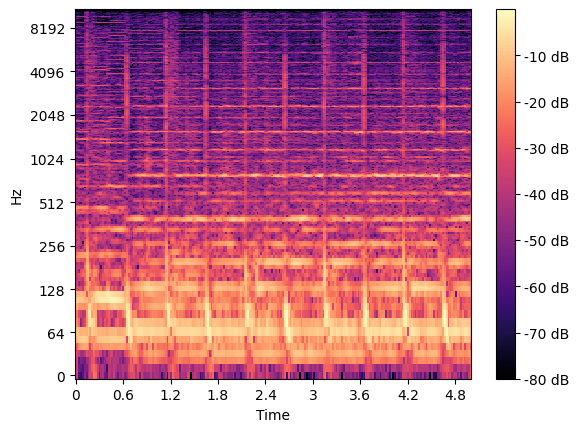

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import os

# Create an "Uploads" folder if it doesn't exist
uploads_folder = "Uploads"
if not os.path.exists(uploads_folder):
    os.makedirs(uploads_folder)

# Ask the user to upload an audio file
print("Please upload an audio file.")
uploaded = files.upload()

# Check if a file was uploaded
if len(uploaded) > 0:
    # Use the first uploaded file
    file_name = list(uploaded.keys())[0]

    # Move the uploaded file to the "Uploads" folder
    new_file_path = os.path.join(uploads_folder, file_name)
    os.rename(file_name, new_file_path)

    y, sr = librosa.load(new_file_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.show()
else:
    print("No audio file uploaded.")


# Identification of Musical Notes and Convertion of the detected notes to MIDI Events



In [ ]:
import locale
locale.getpreferredencoding = lambda: 'UTF-8'
!pip install mido


*Using pydub*

In [ ]:
from pydub import AudioSegment
from pydub.playback import play
import csv
from mido import MidiFile, MidiTrack, Message
from google.colab import files
import os

def pitch_to_midi(pitch):
    midi_notes = [60 + round(pitch) for pitch in pitch]
    return midi_notes

def create_midi_file(midi_notes, output_midi):
    midi_track = MidiTrack()

    for note in midi_notes:
        # You may want to adjust velocity, time, and other parameters
        midi_track.append(Message('note_on', note=note, velocity=64, time=0))
        midi_track.append(Message('note_off', note=note, velocity=64, time=500))  # Adjust duration as needed

    midi_file = MidiFile()
    midi_file.tracks.append(midi_track)
    midi_file.save(output_midi)

def identify_and_generate_midi():
    # Automatically define the output folder path based on the current working directory
    output_folder_path = os.path.join(os.getcwd(), "output_folder")

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # Create a folder for uploaded files
    uploads_folder = os.path.join(output_folder_path, "Uploads")
    if not os.path.exists(uploads_folder):
        os.makedirs(uploads_folder)

    # Loop until a valid audio file is uploaded
    audio = None
    while audio is None:
        # Ask the user to upload an audio file
        print("Please upload an audio file.")
        uploaded = files.upload()

        # Check if a file was uploaded
        if len(uploaded) > 0:
            # Use the first uploaded file
            file_name = list(uploaded.keys())[0]

            try:
                audio = AudioSegment.from_file(file_name)
                # Move the uploaded file to the "Uploads" folder
                os.rename(file_name, os.path.join(uploads_folder, file_name))
            except Exception as e:
                print(f"Invalid audio file: {e}")
        else:
            print("No audio file uploaded. Please upload a valid audio file.")

    detected_notes = []

    for ms in range(0, len(audio), 100):  # Adjust the frame size as needed
        frame = audio[ms:ms+100]
        pitch = frame.dBFS  # This is a simple example; you can use a pitch detection algorithm

        # Ensure that pitch is within a valid range (you may need to adjust this range)
        if -90 <= pitch <= 0:
            detected_notes.append(pitch)

    # Map detected pitch values to MIDI notes
    midi_notes = pitch_to_midi(detected_notes)

    # Create a folder for MIDI files if it doesn't exist
    midi_folder = os.path.join(output_folder_path, "MIDI")
    if not os.path.exists(midi_folder):
        os.makedirs(midi_folder)

    # Create a folder for detected notes CSV files if it doesn't exist
    csv_folder = os.path.join(output_folder_path, "Detected Notes")
    if not os.path.exists(csv_folder):
        os.makedirs(csv_folder)

    # Create output file names
    audio_file_name = os.path.splitext(os.path.basename(file_name))[0]
    csv_output_name = os.path.join(csv_folder, f"Detected_Notes_{audio_file_name}_pydub.csv")
    midi_output_name = os.path.join(midi_folder, f"{audio_file_name}_pydub.mid")

    # Save the detected notes to a CSV file
    with open(csv_output_name, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(midi_notes)

    # Generate a MIDI file from the detected notes
    create_midi_file(midi_notes, midi_output_name)

    return csv_output_name, midi_output_name

# Call the function to identify notes and generate a MIDI file
csv_file, midi_file = identify_and_generate_midi()

# Provide download links for the user
print(f"Detected Notes CSV file: {csv_file}")
print(f"MIDI file: {midi_file}")


Please upload an audio file.


Saving Generated_Audio_Synthwave And Retro Electro_0.wav to Generated_Audio_Synthwave And Retro Electro_0 (1).wav
Detected Notes CSV file: /content/output_folder/Detected Notes/Detected_Notes_Generated_Audio_Synthwave And Retro Electro_0 (1)_pydub.csv
MIDI file: /content/output_folder/MIDI/Generated_Audio_Synthwave And Retro Electro_0 (1)_pydub.mid


*Using aubio*



In [ ]:
import locale
locale.getpreferredencoding = lambda: 'UTF-8'
!pip install aubio

In [ ]:
import os
import csv
import aubio
from mido import MidiFile, MidiTrack, Message
from google.colab import files

# Custom function to convert MIDI note numbers to note names
def midi_to_note(midi_note):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1
    note = midi_note % 12
    return f'{note_names[note]}{octave}'

def create_midi_file(midi_notes, output_midi):
    midi_track = MidiTrack()

    for note in midi_notes:
        # Adjust other parameters as needed
        midi_track.append(Message('note_on', note=note, velocity=64, time=0))
        midi_track.append(Message('note_off', note=note, velocity=64, time=500))  # Adjust duration as needed

    midi_file = MidiFile()
    midi_file.tracks.append(midi_track)
    midi_file.save(output_midi)

def identify_and_generate_midi():
    downsample = 1
    samplerate = 44100 // downsample
    win_s = 512 // downsample  # fft size
    hop_s = 256 // downsample  # hop size

    # Loop until a valid audio file is uploaded
    audio = None
    uploaded_file_path = None  # Store the uploaded file path
    while audio is None:
        # Ask the user to upload an audio file
        print("Please upload an audio file.")
        uploaded = files.upload()

        # Check if a file was uploaded
        if len(uploaded) > 0:
            # Use the first uploaded file
            file_name = list(uploaded.keys())[0]
            uploaded_file_path = file_name

            try:
                audio = aubio.source(uploaded_file_path, samplerate, hop_s)
            except Exception as e:
                print(f"Invalid audio file: {e}")
        else:
            print("No audio file uploaded. Please upload a valid audio file.")

    tolerance = 0.8

    notes_o = aubio.notes("default", win_s, hop_s, samplerate)

    detected_notes = []

    # Total number of frames read
    total_frames = 0
    while True:
        samples, read = audio()
        new_note = notes_o(samples)
        if (new_note[0] != 0):
            note_str = midi_to_note(int(new_note[0]))  # Convert the MIDI note to a string note
            detected_notes.append(int(new_note[0]))  # Convert the MIDI note to an integer
        total_frames += read
        if read < hop_s:
            break

    # Automatically create the folders if they don't exist
    output_folder_path = os.path.join(os.getcwd(), "output_folder")
    folders_to_create = ["MIDI", "Detected Notes"]
    for folder_name in folders_to_create:
        folder_path = os.path.join(output_folder_path, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    # Extract audio file name
    audio_file_name = os.path.splitext(os.path.basename(uploaded_file_path))[0]
    csv_output_name = os.path.join(output_folder_path, "Detected Notes", f"Detected_Notes_{audio_file_name}_aubio.csv")
    midi_output_name = os.path.join(output_folder_path, "MIDI", f"{audio_file_name}_aubio.mid")

    # Save the detected notes to a CSV file
    with open(csv_output_name, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(detected_notes)

    # Generate a MIDI file from the detected notes
    create_midi_file(detected_notes, midi_output_name)

    return csv_output_name, midi_output_name

# Call the function to identify notes and generate a MIDI file
csv_file, midi_file = identify_and_generate_midi()

# Provide download links for the user
print(f"Detected Notes CSV file: {csv_file}")
print(f"MIDI file: {midi_file}")


Please upload an audio file.


Saving Generated_Audio_Synthwave And Retro Electro_0.wav to Generated_Audio_Synthwave And Retro Electro_0 (1).wav
Detected Notes CSV file: /content/output_folder/Detected Notes/Detected_Notes_Generated_Audio_Synthwave And Retro Electro_0 (1)_aubio.csv
MIDI file: /content/output_folder/MIDI/Generated_Audio_Synthwave And Retro Electro_0 (1)_aubio.mid


<ipython-input-82-f63dcc4fa94b>:47: UserWarning: AUBIO WARNING: source_avcodec: upsampling Generated_Audio_Synthwave And Retro Electro_0 (1).wav from 32000 to 44100
  audio = aubio.source(uploaded_file_path, samplerate, hop_s)
